In [59]:
# Import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.pipeline import Pipeline

RSEED = 42

In [60]:
# Import data

# Function to classify if a flight is delayed
def del_ontime(dataf):
    if dataf["target"] == 0:
        return "ot"
    else:
        return "del"

df = pd.read_csv("data/cleaned_data.csv")
df = df[df['target'] <= 480]
df["route"] = df["DEPSTN"] + df["ARRSTN"]
df["strat"] = df.apply(del_ontime, axis=1)

df.head(10)

,DEPSTN,ARRSTN,AC_TYPE,target,flight_duration,month,dayparts,hour_bucket,route,strat
0,CMN,TUN,32A,260.0,145.0,Jan,Morning,h10,CMNTUN,del
1,MXP,TUN,31B,20.0,110.0,Jan,Afternoon,h15,MXPTUN,del
2,TUN,IST,32A,0.0,155.0,Jan,Night,h04,TUNIST,ot
3,DJE,NTE,736,0.0,170.0,Jan,Afternoon,h14,DJENTE,ot
4,TUN,ALG,320,22.0,80.0,Jan,Afternoon,h14,TUNALG,del
5,TLS,TUN,736,53.0,115.0,Jan,Afternoon,h16,TLSTUN,del
6,TUN,BCN,32A,10.0,105.0,Jan,Early Morning,h07,TUNBCN,del
7,TUN,ORY,32A,15.0,140.0,Jan,Early Morning,h07,TUNORY,del
8,TUN,FCO,32A,16.0,80.0,Jan,Early Morning,h07,TUNFCO,del
9,TUN,NCE,31A,21.0,90.0,Jan,Early Morning,h07,TUNNCE,del


In [61]:
# set categorical and numerical parameters, which will be used during regression
cat_vars = ['hour_bucket', 'strat', "ARRSTN", "AC_TYPE", "month"]
num_vars = ['flight_duration']

df1 = df[num_vars].copy()
df2 = pd.get_dummies(df[cat_vars], dtype = int, drop_first=True)
df1 = pd.concat([df1, df2], axis=1)

# df1 is constructed as X
X = df1.copy()
y = df["target"]
X

,flight_duration,hour_bucket_h01,hour_bucket_h02,hour_bucket_h03,hour_bucket_h04,hour_bucket_h05,hour_bucket_h06,hour_bucket_h07,hour_bucket_h08,hour_bucket_h09,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,145.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,110.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,155.0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,170.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,80.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93674,50.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
93675,145.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
93676,45.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
93677,35.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=X["strat_ot"], random_state = RSEED)


# drop the category if a flight is delayed. It was only used for splitting, not for regression! 
X_train = X_train.drop(["strat_ot"], axis=1)
X_test = X_test.drop(["strat_ot"], axis=1)
X_train

,flight_duration,hour_bucket_h01,hour_bucket_h02,hour_bucket_h03,hour_bucket_h04,hour_bucket_h05,hour_bucket_h06,hour_bucket_h07,hour_bucket_h08,hour_bucket_h09,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
60345,175.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
54503,150.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
62497,120.0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16132,295.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
83894,130.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65868,150.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
53843,145.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48342,110.0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
65935,170.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [63]:
# "final" model of random froest regression. Parameters where determined by GridSerachCV which was done below
model_ranfor = RandomForestRegressor(n_estimators=350, 
                               random_state=RSEED, 
                               max_features = 35,
                               max_depth = 45,
                               min_samples_split = 75,
                               n_jobs = -1, 
                               verbose = 1)

model_ranfor.fit(X_train, y_train)

# Prediction with X_test and calculation of RMSE
ranfor_predictions = model_ranfor.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, ranfor_predictions)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s


Root Mean Squared Error (RMSE): 69.90034652389211


[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    2.5s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 350 out of 350 | elapsed:    0.0s finished


In [ ]:
# Defining first part of pipeline. It is sparse, because there is no need to scale when running Random Forest
pipe_ranfor = Pipeline([
                        ('random_forest', RandomForestRegressor(random_state=RSEED))
                       ])

In [ ]:
# First round of GridSearchCV

In [99]:
param_ranfor_1 = {'random_forest__n_estimators': [150, 200],
                'random_forest__max_depth': [20, 25],
                'random_forest__min_samples_split': [50, 75]
               }

grid_ranfor_1 = GridSearchCV(pipe_ranfor, param_grid=param_ranfor_1, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=2, n_jobs=-1)

In [100]:
grid_ranfor_1.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [20, 25],
                         'random_forest__min_samples_split': [50, 75],
                         'random_forest__n_estimators': [150, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [101]:
best_model_1 = grid_ranfor_1.best_estimator_
best_model_1

Pipeline(steps=[('random_forest',
                 RandomForestRegressor(max_depth=25, min_samples_split=75,
                                       n_estimators=200, random_state=42))])

In [102]:
print('Best score:\n{:.2f}'.format(grid_ranfor_1.best_score_))
print("Best parameters:\n{}".format(grid_ranfor_1.best_params_))

Best score:
-70.54
Best parameters:
{'random_forest__max_depth': 25, 'random_forest__min_samples_split': 75, 'random_forest__n_estimators': 200}


In [103]:
y_test_predicted_ranforgrid_1 = best_model_1.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted_ranforgrid_1)))

Root Mean Squared Error (RMSE): 70.20559037201484


In [ ]:
# Second round of GridSearchCV

In [104]:
param_ranfor_2 = {'random_forest__n_estimators': [200, 250],
                'random_forest__max_depth': [25, 30, 35],
                'random_forest__min_samples_split': [70, 75, 80],
                'random_forest__max_features': [30, 35, 40, 50]
               }

grid_ranfor_2 = GridSearchCV(pipe_ranfor, param_grid=param_ranfor_2, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=3, n_jobs=-1)

In [105]:
grid_ranfor_2.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [25, 30, 35],
                         'random_forest__max_features': [30, 35, 40, 50],
                         'random_forest__min_samples_split': [70, 75, 80],
                         'random_forest__n_estimators': [200, 250]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [108]:
best_model_2 = grid_ranfor_2.best_estimator_
best_model_2

Pipeline(steps=[('random_forest',
                 RandomForestRegressor(max_depth=35, max_features=35,
                                       min_samples_split=75, n_estimators=250,
                                       random_state=42))])

In [109]:
print('Best score:\n{:.2f}'.format(grid_ranfor_2.best_score_))
print("Best parameters:\n{}".format(grid_ranfor_2.best_params_))

Best score:
-70.26
Best parameters:
{'random_forest__max_depth': 35, 'random_forest__max_features': 35, 'random_forest__min_samples_split': 75, 'random_forest__n_estimators': 250}


In [110]:
y_test_predicted_ranforgrid_2 = best_model_2.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted_ranforgrid_2)))

Root Mean Squared Error (RMSE): 69.92198945773893


In [ ]:
# Third round of GridSearchCV

In [111]:
param_ranfor_3 = {'random_forest__n_estimators': [250, 300, 350],
                'random_forest__max_depth': [35, 40, 45],
                'random_forest__min_samples_split': [75],
                'random_forest__max_features': [35, 40]
               }

grid_ranfor_3 = GridSearchCV(pipe_ranfor, param_grid=param_ranfor_3, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=3, n_jobs=-1)

In [112]:
grid_ranfor_3.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [35, 40, 45],
                         'random_forest__max_features': [35, 40],
                         'random_forest__min_samples_split': [75],
                         'random_forest__n_estimators': [250, 300, 350]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [114]:
best_model_3 = grid_ranfor_3.best_estimator_
best_model_3

Pipeline(steps=[('random_forest',
                 RandomForestRegressor(max_depth=45, max_features=35,
                                       min_samples_split=75, n_estimators=350,
                                       random_state=42))])

In [115]:
print('Best score:\n{:.2f}'.format(grid_ranfor_3.best_score_))
print("Best parameters:\n{}".format(grid_ranfor_3.best_params_))

Best score:
-70.23
Best parameters:
{'random_forest__max_depth': 45, 'random_forest__max_features': 35, 'random_forest__min_samples_split': 75, 'random_forest__n_estimators': 350}


In [116]:
y_test_predicted_ranforgrid_3 = best_model_3.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted_ranforgrid_3)))

Root Mean Squared Error (RMSE): 69.9003465238921


In [ ]:
#### Start of plotting part for results ####

In [12]:
# Group the data by hour and calculate the mean delay
df_X = pd.read_csv("data/cleaned_data.csv")
df_X = df[df['target'] <= 480]

mean_delay_per_hour = df_X.groupby('hour_bucket')['target'].mean() #.sort_values(ascending=False)
mean_delay_per_hour




hour_bucket
h00    68.576170
h01    65.486716
h02    52.284653
h03    24.975446
h04    29.649205
h05    23.600517
h06    22.720979
h07    26.090806
h08    33.126229
h09    39.009174
h10    35.816749
h11    40.163892
h12    49.742620
h13    52.219061
h14    53.808364
h15    56.747757
h16    68.637661
h17    57.872575
h18    58.645599
h19    69.994413
h20    51.345765
h21    48.739362
h22    52.885699
h23    57.103896
Name: target, dtype: float64

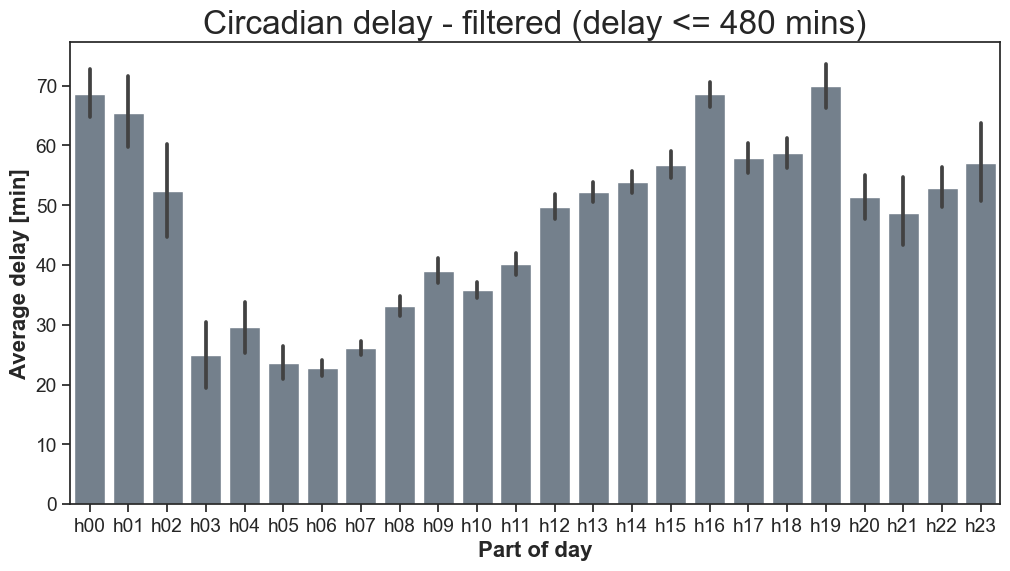

In [13]:
# Set plot size and style
plt.figure(figsize=(12, 6))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.barplot(data=df_X, x="hour_bucket", y="target", errorbar=('ci', 95), color="slategrey", order=mean_delay_per_hour.index)
g.figure.set_size_inches(12, 6)


# Set titles and labels
plt.title('Circadian delay - filtered (delay <= 480 mins)', fontsize=24)
plt.xlabel('Part of day', fontsize=16, fontweight='bold')
plt.ylabel('Average delay [min]', fontsize=16, fontweight='bold')

plt.show()

In [14]:
# same function as used above to classify
def del_ontime(dataf):
    if dataf["target"] == 0:
        return "ot"
    else:
        return "del"

# Very clumsy but working function to calculate baseline model values (y = 2*x + 25)
def baseline_func(dataf):
    
    if dataf["hour_bucket"] == "h03":
        return 0*2 + 25
    elif dataf["hour_bucket"] == "h04":
        return 1*2 + 25
    elif dataf["hour_bucket"] == "h05":
        return 2*2 + 25
    elif dataf["hour_bucket"] == "h06":
        return 3*2 + 25
    elif dataf["hour_bucket"] == "h07":
        return 4*2 + 25
    elif dataf["hour_bucket"] == "h08":
        return 5*2 + 25
    elif dataf["hour_bucket"] == "h09":
        return 6*2 + 25
    elif dataf["hour_bucket"] == "h10":
        return 7*2 + 25
    elif dataf["hour_bucket"] == "h11":
        return 8*2 + 25
    elif dataf["hour_bucket"] == "h12":
        return 9*2 + 25
    elif dataf["hour_bucket"] == "h13":
        return 10*2 + 25
    elif dataf["hour_bucket"] == "h14":
        return 11*2 + 25
    elif dataf["hour_bucket"] == "h15":
        return 12*2 + 25
    elif dataf["hour_bucket"] == "h16":
        return 13*2 + 25
    elif dataf["hour_bucket"] == "h17":
        return 14*2 + 25
    elif dataf["hour_bucket"] == "h18":
        return 15*2 + 25
    elif dataf["hour_bucket"] == "h19":
        return 16*2 + 25
    elif dataf["hour_bucket"] == "h20":
        return 17*2 + 25
    elif dataf["hour_bucket"] == "h21":
        return 18*2 + 25
    elif dataf["hour_bucket"] == "h22":
        return 19*2 + 25
    elif dataf["hour_bucket"] == "h23":
        return 20*2 + 25
    elif dataf["hour_bucket"] == "h00":
        return 21*2 + 25
    elif dataf["hour_bucket"] == "h01":
        return 22*2 + 25
    elif dataf["hour_bucket"] == "h02":
        return 23*2 + 25


# freshly import data, filter and calculate baseline model values
df_baseline_filtered = pd.read_csv("data/cleaned_data.csv")
df_baseline_filtered = df[df['target'] <= 480]
df_baseline_filtered["route"] = df_baseline_filtered["DEPSTN"] + df_baseline_filtered["ARRSTN"]
df_baseline_filtered["strat"] = df_baseline_filtered.apply(del_ontime, axis=1)
df_baseline_filtered["baseline"] = df_baseline_filtered.apply(baseline_func, axis=1)



df1_bl_f = df_baseline_filtered[num_vars].copy()
df2_bl_f = pd.get_dummies(df_baseline_filtered[cat_vars], dtype = int, drop_first=True)
df1_bl_f = pd.concat([df1_bl_f, df2_bl_f], axis=1)


cat_vars = ['hour_bucket', 'strat', "ARRSTN", "AC_TYPE", "month"]
num_vars = ['flight_duration', 'baseline']

df1_bl_f = df_baseline_filtered[num_vars].copy()
df2_bl_f = pd.get_dummies(df_baseline_filtered[cat_vars], dtype = int, drop_first=True)
df1_bl_f = pd.concat([df1_bl_f, df2_bl_f], axis=1)

# df1 is constructed as X

X_bl_f = df1_bl_f.copy()
y_bl_f = df_baseline_filtered["target"]


# all the stuff needed to be split again to have corresponding/fitting baseline function values
X_train_bl_f, X_test_bl_f, y_train_bl_f, y_test_bl_f = train_test_split(X_bl_f, y_bl_f, test_size = 0.25, stratify=X_bl_f["strat_ot"], random_state = RSEED)
X_train_bl_f = X_train_bl_f.drop(["strat_ot"], axis=1)
X_test_bl_f = X_test_bl_f.drop(["strat_ot"], axis=1)

y_pred_baseline_f = X_test_bl_f["baseline"]
y_pred_baseline_f


29760    57
88646    37
15120    45
9188     69
88375    51
         ..
77438    61
79376    49
188      45
32248    35
83887    45
Name: baseline, Length: 23114, dtype: int64

In [15]:
# calculation of RMSE for the baseline function
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_baseline_f)))

Root Mean Squared Error (RMSE): 73.73297096989292


In [ ]:
# construct one dataframe with y_test, predictions made by baseline function and predictions made by random forest model
y_test_pred_ranfor_to_merge = pd.Series(ranfor_predictions)
y_test_pred_ranfor_to_merge.name = "random_forest"

plot_data_f = pd.concat([y_test, y_pred_baseline_f], axis=1)
plot_data_f.reset_index(drop=True, inplace=True)
plot_data_f = pd.concat([plot_data_f, y_test_pred_ranfor_to_merge], axis=1)

<Figure size 1200x500 with 0 Axes>

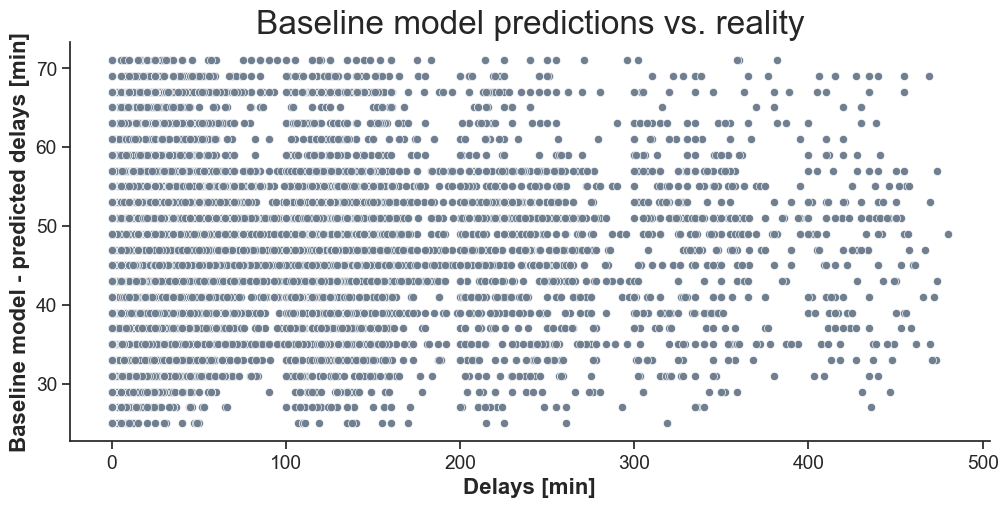

In [26]:
### Figures with data that is filtered (delay <= 480 minutes) ####
##################################################################


# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="target", y="baseline", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches((12, 5))

# Set titles and labels
plt.title('Baseline model predictions vs. reality', fontsize=24)
plt.xlabel('Delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Baseline model - predicted delays [min]', fontsize=16, fontweight='bold')

plt.show()

<Figure size 1200x500 with 0 Axes>

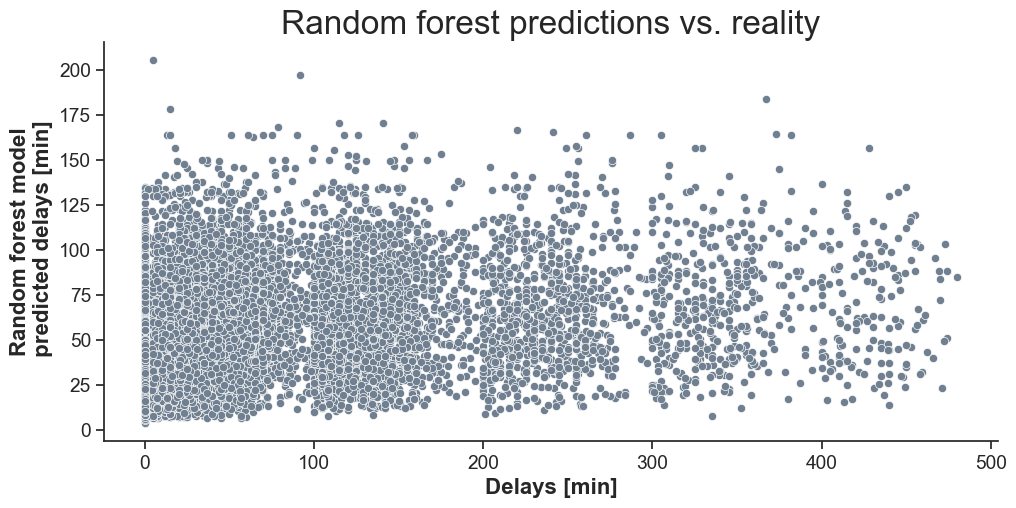

In [36]:
# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="target", y="random_forest", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches(12, 5)

# Set titles and labels
plt.title('Random forest predictions vs. reality', fontsize=24)
plt.xlabel('Delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Random forest model\n predicted delays [min]', fontsize=16, fontweight='bold')

plt.show()

<Figure size 1200x600 with 0 Axes>

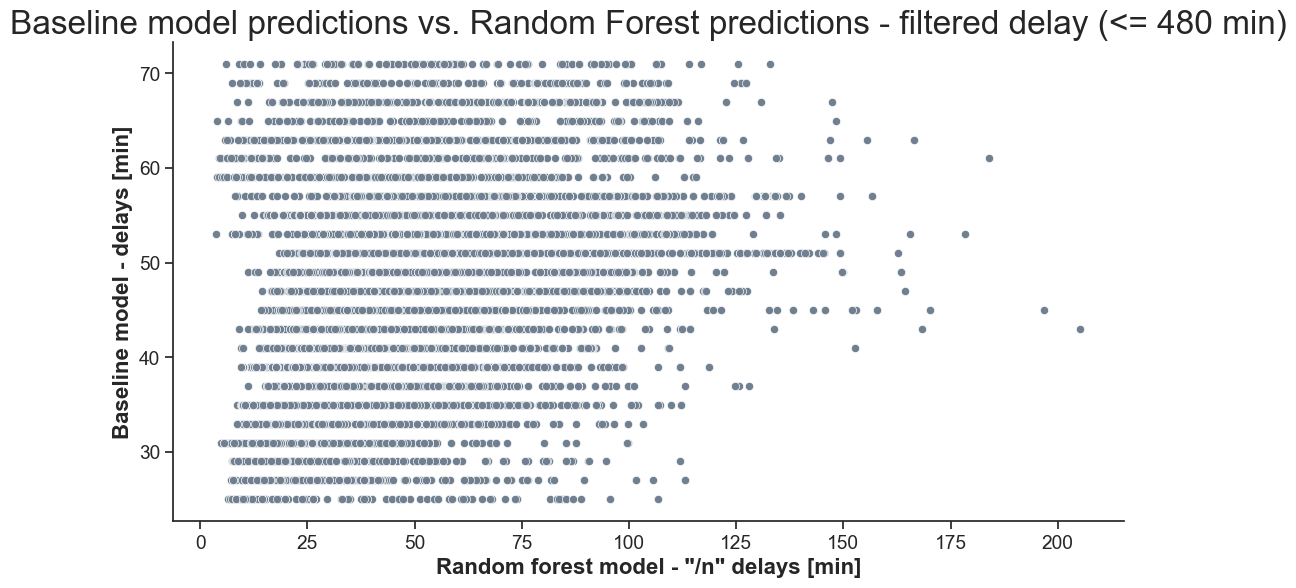

In [30]:
# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="random_forest", y="baseline", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches(12, 6)

# Set titles and labels
plt.title('Baseline model predictions vs. Random Forest predictions - filtered delay (<= 480 min)', fontsize=24)
plt.xlabel('Random forest model - delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Baseline model - delays [min]', fontsize=16, fontweight='bold')

plt.show()

In [ ]:
# calculation of errors/residuals to have them for error plots

plot_data_f["baseline_error"] = plot_data_f["target"] - plot_data_f["baseline"] 
plot_data_f["ranfor_error"] = plot_data_f["target"] - plot_data_f["random_forest"]

<Figure size 1200x500 with 0 Axes>

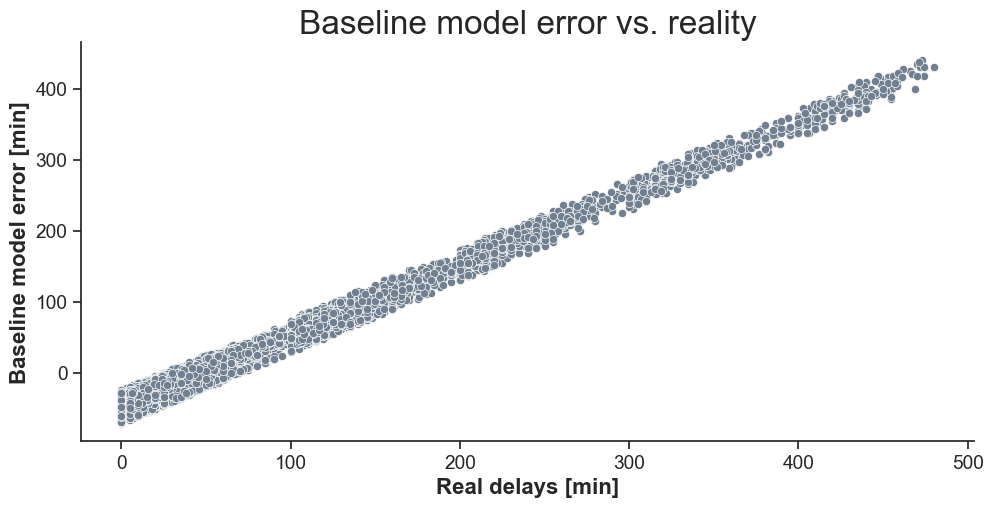

In [48]:
# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="target", y="baseline_error", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches((12, 5))

# Set titles and labels
plt.title('Baseline model error vs. reality', fontsize=24)
plt.xlabel('Real delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Baseline model error [min]', fontsize=16, fontweight='bold')

plt.show()

<Figure size 1200x500 with 0 Axes>

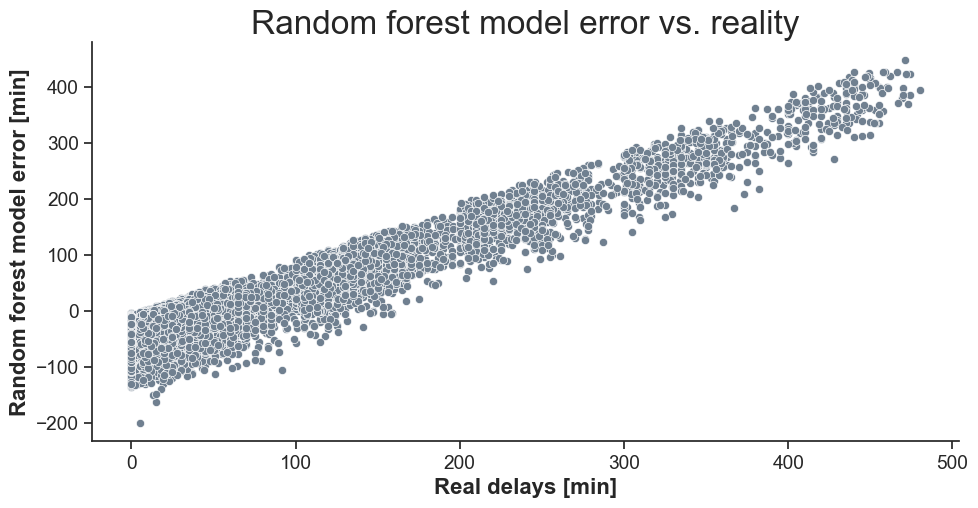

In [49]:
# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="target", y="ranfor_error", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches((12, 5))

# Set titles and labels
plt.title('Random forest model error vs. reality', fontsize=24)
plt.xlabel('Real delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Random forest model error [min]', fontsize=16, fontweight='bold')

plt.show()

<Figure size 1200x500 with 0 Axes>

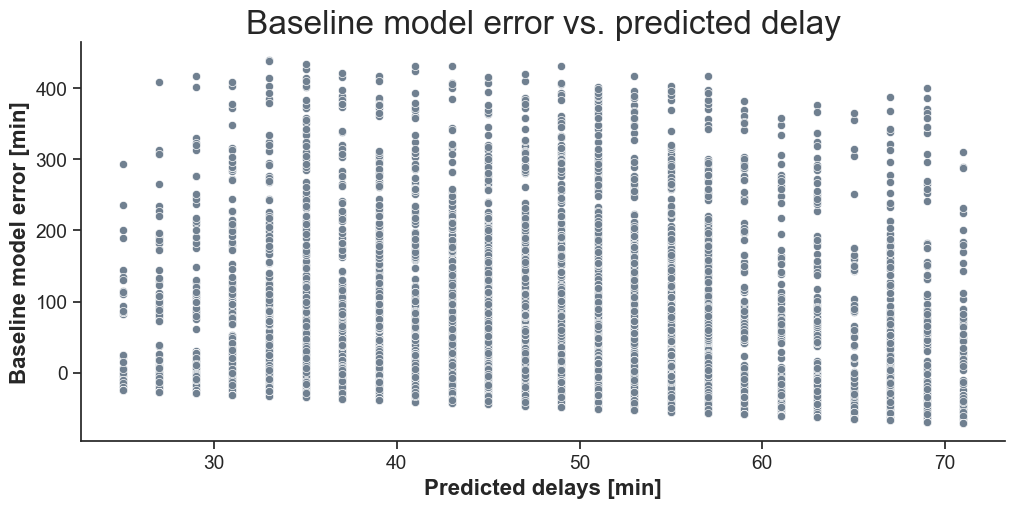

In [50]:
# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="baseline", y="baseline_error", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches((12, 5))

# Set titles and labels
plt.title('Baseline model error vs. predicted delay', fontsize=24)
plt.xlabel('Predicted delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Baseline model error [min]', fontsize=16, fontweight='bold')

plt.show()

<Figure size 1200x500 with 0 Axes>

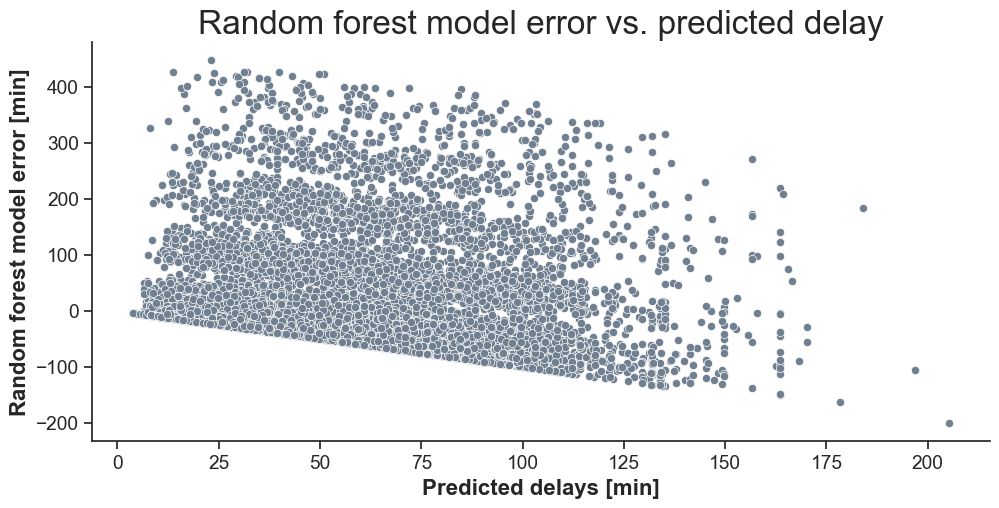

In [51]:
# Set figure size and style
plt.figure(figsize=(12, 5))
sns.set_theme(style="ticks", font_scale=1.25)

g = sns.relplot(data=plot_data_f, x="random_forest", y="ranfor_error", s=35, kind="scatter", color="slategrey")
g.ax.margins(.05)
g.despine()
g.figure.set_size_inches((12, 5))

# Set titles and labels
plt.title('Random forest model error vs. predicted delay', fontsize=24)
plt.xlabel('Predicted delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Random forest model error [min]', fontsize=16, fontweight='bold')

plt.show()

In [ ]:
#### Density plots are just for fun ####

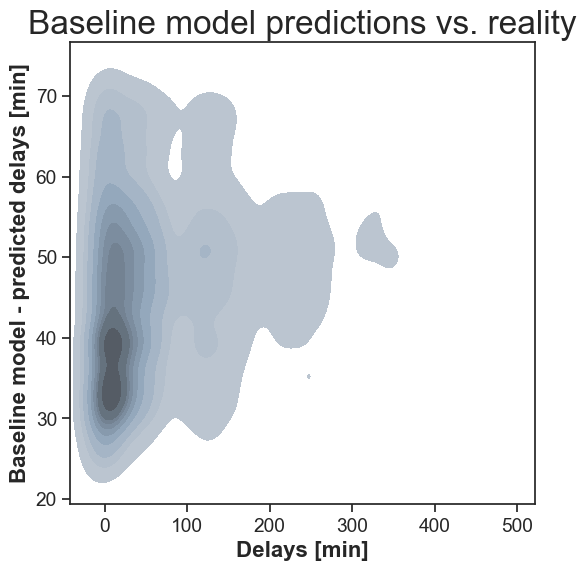

In [57]:
# Set figure size and style
plt.figure(figsize=(6, 6))
# sns.set_theme(style="ticks", font_scale=1.25)

g = sns.kdeplot(data=plot_data_f, x="target", y="baseline", fill=True, color="slategrey")
g.figure.set_size_inches((6, 6))

# Set titles and labels
plt.title('Baseline model predictions vs. reality', fontsize=24)
plt.xlabel('Delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Baseline model - predicted delays [min]', fontsize=16, fontweight='bold')

plt.show()

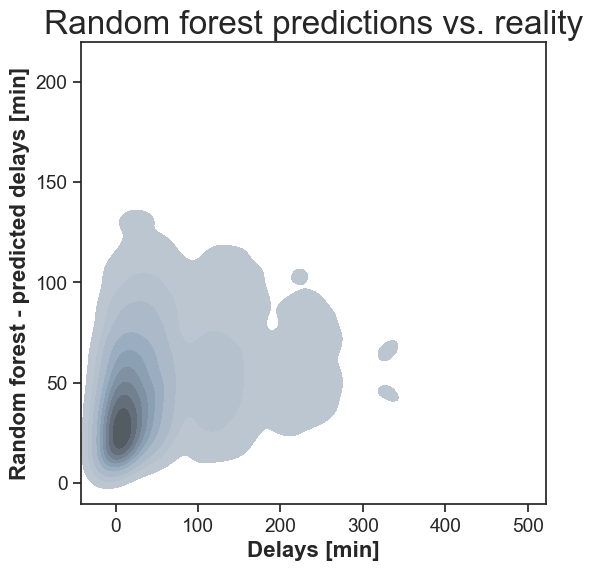

In [58]:
# Set figure size and style
plt.figure(figsize=(6, 6))
# sns.set_theme(style="ticks", font_scale=1.25)

g = sns.kdeplot(data=plot_data_f, x="target", y="random_forest", fill=True, color="slategrey")
g.figure.set_size_inches((6, 6))

# Set titles and labels
plt.title('Random forest predictions vs. reality', fontsize=24)
plt.xlabel('Delays [min]', fontsize=16, fontweight='bold')
plt.ylabel('Random forest - predicted delays [min]', fontsize=16, fontweight='bold')

plt.show()